In [341]:
#IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mathematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files
import scipy.signal as signal 
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull

In [342]:
# KEY PARAMETERS USED THROUGHOUT MODEL

a = 350 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = np.float64(100000000) # Budget in £ to build the wind farm, accounting for construction costs.
DistanceToShore = 15000 # m #distance of the wind farm from shore
TooCloseShore = 5000 # m # minimum distance the wind farm must be from shore
xCoordOnshoreSub = 0 # x coordinate of the onshore substation (y coordinate is -(DistanceToShore))

USDtoGBP = 1/1.351  
EURtoGBP = 1/1.19

IACableCostperMeter = 409.2*EURtoGBP
ExportCableCostperMeter = 833.625*EURtoGBP

CostperTurbineUSD = np.float64(3000000) # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = np.float64(65500) # GBP
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP

OffshoreSubstationCostperMW = np.float64(104000*EURtoGBP)
OnshoreSubstationCostperMW = np.float64(87250*EURtoGBP)
# Costs  associated with the purchase and installation of electrical substations as well as the buildings required for housing the staff and additional equipment required for the running of the wind farm.

ElectricityCostperkWh = 0.144 # 14.4 pence - £0.144
DiscountRate = 0.07 # 7%

TurbineRating = 2 #2MW

GravityBase = 409000*EURtoGBP*TurbineRating #409000euro/MW
Monopile = 551000*EURtoGBP*TurbineRating
Jacket = 665000*EURtoGBP*TurbineRating
TensionLeg = 1163000*EURtoGBP*TurbineRating

In [343]:
#READING IN BATHYMETRY DATA
data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'    
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [344]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.    
maxnodespertree = maximumturbinespertree # As above
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result
MinIACableCostPerTurbine = a*IACableCostperMeter
MinExportCableCost = TooCloseShore*ExportCableCostperMeter # minimum export cable cost with respect to the minimum distance the wind farm must be form shore
MinFoundationCostPerTurbine = GravityBase*TurbineRating

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine+MinIACableCostPerTurbine+MinFoundationCostPerTurbine # Total costs (excluding export cable and fixed costs)
nnturb = (budget-MinExportCableCost)/MinCostperTurbTot 
FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nnturb*TurbineRating # *2 due to 2MW turbines being used *0.4 for assuming 40% effciency
nturb = (budget-FixedCost-MinExportCableCost)/(MinCostperTurbTot) # Turbines possible with current budget
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3615.099925980903
Min area per turbine = 106088.11196359372 m^2
Min area = 1803497.9033810932 m^2
Max number of turbines = 17
Max area = 132501886.77901912 m^2


In [345]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-0.5a,-0.5aroot3) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
        
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

[[   0.            0.        ]
 [ 350.            0.        ]
 [ 525.          303.10889132]
 [ 175.          303.10889132]
 [-175.          303.10889132]
 [-350.            0.        ]
 [-525.         -303.10889132]
 [-175.         -303.10889132]
 [ 175.         -303.10889132]
 [ 525.         -303.10889132]
 [ 700.            0.        ]
 [ 875.          303.10889132]
 [1050.          606.21778265]
 [ 700.          606.21778265]
 [ 350.          606.21778265]
 [   0.          606.21778265]
 [-350.          606.21778265]
 [-525.          303.10889132]]
18


In [346]:
# Shoreline implementation

XShoreLine = np.array([np.linspace(min(positionlist[:,0])-2500,max(positionlist[:,0])+2500,1000)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m # 1000 data points
YShoreLine = np.array([np.linspace(-DistanceToShore,-DistanceToShore,1000)]) #Creates y coordinates of shoreline at -(distance of the wind farm from the shore) # 1000 data points
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLine = np.transpose(YShoreLine) #transpose of y coordinates
TShoreLine = np.concatenate((TXShoreLine,TYShoreLine),axis=1) # Shoreline (x,y)

In [347]:
# Finds distance between substation and shore

def Substation_To_Shore_Connection(positionlist):
    
    OnshoreSubstation = [xCoordOnshoreSub,-DistanceToShore] # Determines fixed position of onshore substation
    ExportDistance = np.sqrt(((positionlist[0,0]-OnshoreSubstation[0])**2)+((positionlist[0,1]-OnshoreSubstation[1])**2)) # min Hypotenuse for distances between substations
    
    return OnshoreSubstation,ExportDistance

OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist) #Initially Executes algorithm

print(OnshoreSubstation)
print(np.shape(OnshoreSubstation))
print(ExportDistance)

[0, -15000]
(2,)
15000.0


In [348]:
# Pushes wind farm further out if the smallest distance between the shore and center of wind farm is too small
# Only used for the pre-optimised layout
#In terms of keeping it this way there are bounds on (minimize(targetfunction, initial guess, bounds,.....etc.) the optimization function

CloseTurbY = min(positionlist[:,1]) # y coordinate of closest turbine
CloseTurbYindex = np.argmin(positionlist[:,1]) # index from closest turbine on y axis
CloseTurbX = positionlist[CloseTurbYindex,0] # x coordinate of closest turbine on y axis
DistanceToMinTurb = min(np.sqrt((CloseTurbX-TXShoreLine[:,0])**2+(CloseTurbY-TYShoreLine[:,0])**2)) #min distance from shore to closest turbine 
s = 0

if DistanceToMinTurb < TooCloseShore: # if closest turbine is too close to the shore
    for s in range(0,nturb+1): # loops for number of turbines plus the substation
        positionlist[s,1] = positionlist[s,1] + (TooCloseShore-DistanceToMinTurb)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required
    Substation_To_Shore_Connection(positionlist) #Calls function to redo substation to shore connection with new values

(-16303.108891324553, -403.1088913245535)

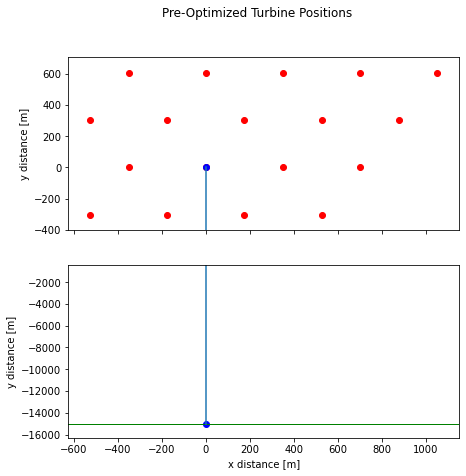

In [349]:
# Display pre-optimized turbine positions before clustering and MST

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)    
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

In [350]:
#Function to determine land cost of wind farm using a convex hull
#Calcualtes area of wind farm, onshore substation, and export cable
#Won't work for just 1 turbine since no boundary to enclose

def LandAreaCost(positionlist,ExportDistance):
    
    radius = 130 #m
    OnshoreSubLand = np.pi*radius**2 #Land area associated with the onshore substation
    ExportLand = ExportDistance*8 # Length*width 
    
    hull = ConvexHull(positionlist) #computes convex hull using the turbine positions
    LandArea = hull.volume + OnshoreSubLand + ExportLand #Calcualtes convex hull area and adds on the onshore substation land area

    LandCost = LandArea*LandCostpermSquared
    
    return LandCost

LandCost = LandAreaCost(positionlist,ExportDistance)

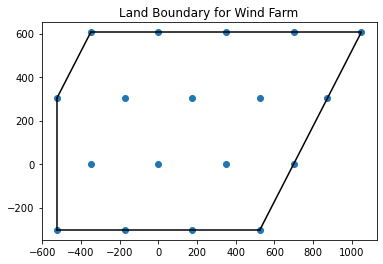

In [351]:
#Visual aid for convex hull plotting

hull = ConvexHull(positionlist)
plt.plot(positionlist[:,0], positionlist[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(positionlist[simplex, 0], positionlist[simplex, 1], 'k-')


plt.title('Land Boundary for Wind Farm')
plt.show()

C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Function run time: 0.15774390002479777
[[   0    3    4    5    6    7    8   15   16   17 -100]
 [   0    1    2    9   10   11   12   13   14 -100 -100]]


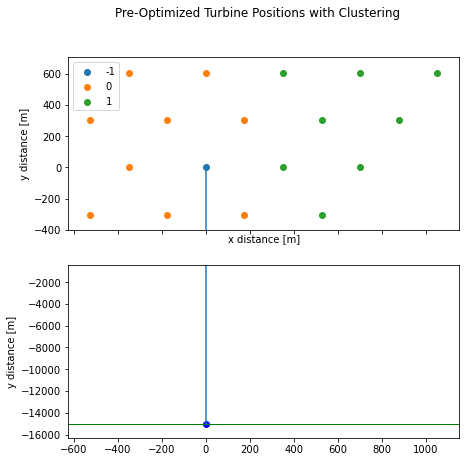

In [352]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustering')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
for i in u_labels: # loops for number of turbines
    ax1.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax1.legend() # prints legend
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

print(indiceslist)

In [353]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

#distance_global - distances of each turbine with respect to the substation and each other h=sqrt(x^2+y^2)
#e.g. row 0 would be each turbines distance with respect to the substation
# and row 4 would be each turbines distance with respect to the 4th turbine as found in the position list
# distance_globl[i,i] = 1e10 since this is the distance of each turbine with respect to itself so we want the MST to ignore thse values
#angle_global - angle of each turbine with respect to the substation and each other arctan(y/x)
#distance and angle then do something similar but considering the cluster formations as well

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1) # Everything except the -100 ones which were denoted earlier to show that there is no turbine at that index
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [354]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()
    return MSTweight

Each tree weight tree 1 3150000.0
Each tree weight tree 2 2800000.0
MST total weight 5950000.0 m


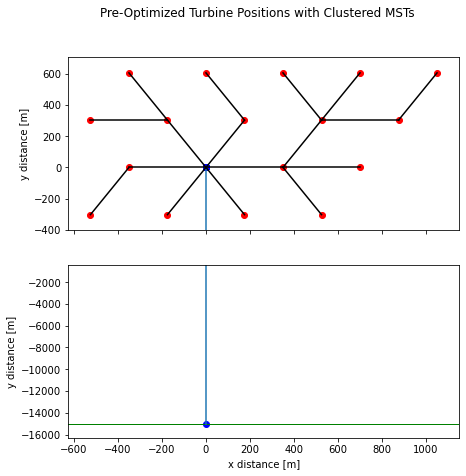

In [355]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustered MSTs')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax1.plot(u,v, c='black')
        ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [356]:
#DISPLAYS RAW BATHYMETRY DATA

print(data) # Prints out bathymetry data - Read in using pandas in previous section

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...  MAG_RESSEN  MAG_DICORR  \
0 

In [357]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

print(data) 

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...   GRA_OBS  EOTVOS  FREEAIR  \

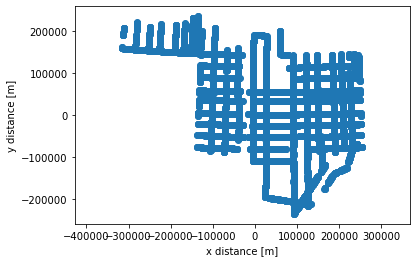

In [358]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

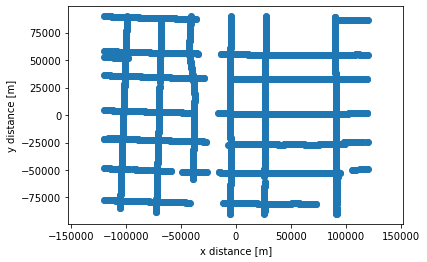

In [359]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

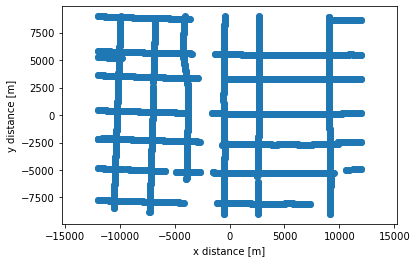

In [360]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

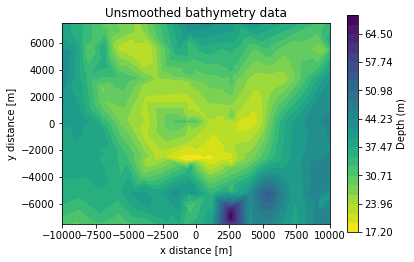

In [361]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

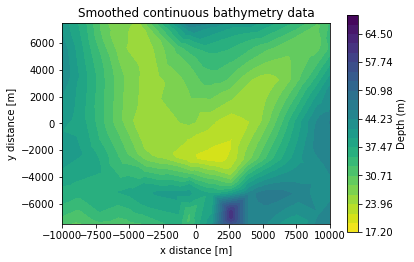

In [362]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [363]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = np.float64(0) # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(2825169.6412788685, 24.435653877898705, 27.064755136536917)

In [364]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=5. #[degrees]

In [365]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [366]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=5 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [367]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


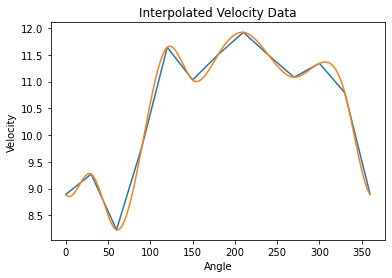

In [368]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

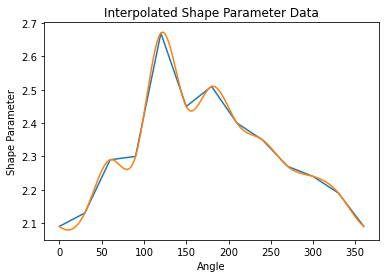

In [369]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

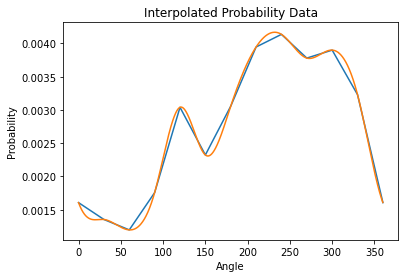

In [370]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [371]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

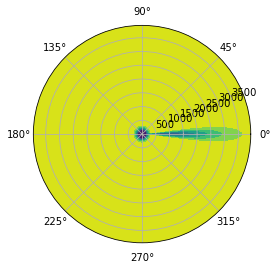

0.580003843


In [372]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [373]:
# # isn't useful for continuing code, just rotates the windfarm.
# def rotate(angle,coords):
#     angle = np.pi*angle/180.
#     rotcoordx = []
#     rotcoordy = []
#     for coord in coords:
#         rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
#         rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
#     rotcoords=[rotcoordx,rotcoordy]
#     rotcoords=np.array(rotcoords).T   
#     return rotcoords 
# #print rotate(254,coords)[:,0]
# plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [374]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [375]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [376]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the % of wind that arrives at a turbine for a certain angle.
# Starts with assumption that there's zero wake so all turbines get full wind.
#talked about
#Total att
def windspeedreduction(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.

In [377]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [378]:
#GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [379]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [380]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [381]:
wind_dist(1.0,v0)

0.024244336764100854

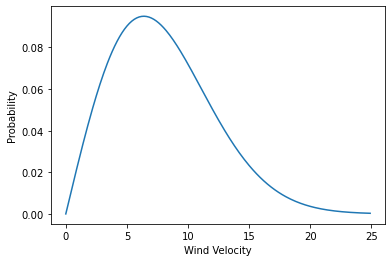

In [382]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [383]:
velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)

[[7.95303494e-04 9.80036676e-04 1.05789271e-03 ... 6.39190809e-05
  3.40253887e-05 1.70630457e-05]
 [7.34767202e-04 9.01764403e-04 9.69915308e-04 ... 5.75583274e-05
  3.06371248e-05 1.53701909e-05]
 [6.87320078e-04 8.44491359e-04 9.10294073e-04 ... 5.77144043e-05
  3.11157981e-05 1.58295009e-05]
 ...
 [9.80182139e-04 1.25683306e-03 1.41621103e-03 ... 1.55577912e-04
  9.05953796e-05 4.99151675e-05]
 [9.27369324e-04 1.17045619e-03 1.29626789e-03 ... 1.10756647e-04
  6.20462178e-05 3.28196113e-05]
 [8.63068120e-04 1.07416013e-03 1.17166708e-03 ... 8.08008629e-05
  4.38237311e-05 2.24068824e-05]] (72, 14) 0.9458659589195532
(14,)


In [384]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

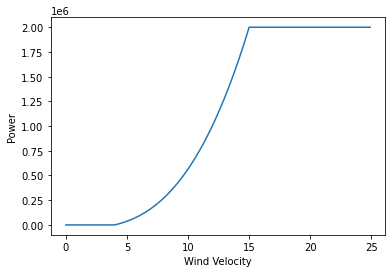

In [385]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [386]:
wsr=windspeedreduction(distance,angle,angles,model)
print(wsr)
powout=power(wsr,velocities)
wsr

[[0.81184717 0.86872074 0.93521454 ... 0.93610334 0.93521454 0.86872074]
 [0.92387216 0.92387216 0.92387216 ... 0.92387216 0.92387216 0.92387216]
 [0.93607527 0.93607527 0.93607527 ... 0.93607527 0.93607527 0.93607527]
 ...
 [0.94857924 0.94857924 0.94857924 ... 0.94857924 0.94857924 0.94857924]
 [0.96116892 0.96116892 0.96116892 ... 0.96116892 0.96116892 0.96116892]
 [0.96116763 0.96116763 0.96116763 ... 0.96116763 0.96116763 0.96116763]]


array([[0.81184717, 0.86872074, 0.93521454, ..., 0.93610334, 0.93521454,
        0.86872074],
       [0.92387216, 0.92387216, 0.92387216, ..., 0.92387216, 0.92387216,
        0.92387216],
       [0.93607527, 0.93607527, 0.93607527, ..., 0.93607527, 0.93607527,
        0.93607527],
       ...,
       [0.94857924, 0.94857924, 0.94857924, ..., 0.94857924, 0.94857924,
        0.94857924],
       [0.96116892, 0.96116892, 0.96116892, ..., 0.96116892, 0.96116892,
        0.96116892],
       [0.96116763, 0.96116763, 0.96116763, ..., 0.96116763, 0.96116763,
        0.96116763]])

In [387]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
output=np.zeros((nturb)) 
output=np.tensordot(powout,wsp,2)
print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

[681934.12475031 646241.73520281 677814.44391097 691362.15659513
 732999.81493344 795014.74902127 758435.06476818 741548.21524151
 726444.48469771 685681.2535814  676880.56048476 712486.50824368
 675337.99772164 680349.94768707 693112.60611422 724136.46830948
 748621.23950763] (17,) 12048401.370771196


In [388]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078] (17,) 14741731.221373294


In [389]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [390]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [391]:
distance,angle,distance_global, angle_global = geom_analysis(positionlist,indiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

In [392]:
def foundationDepthCost(foundation,DepthPerTurbine):
    
    FoundationCost = foundation*(0.0002*(float(DepthPerTurbine)**2) - 0.0002*(float(DepthPerTurbine)) + 0.9459)
    
    return FoundationCost

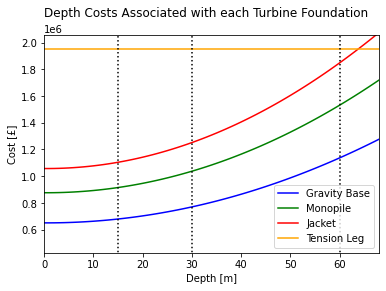

In [393]:
# Plots depth functions for each individual turbine foundation type

Depthx = range(0,math.ceil((max(data['CORR_DEPTH']))),1)
GBCost = [None] * len(Depthx)
MPCost = [None] * len(Depthx)
JCost = [None] * len(Depthx)
TLCost = [None] * len(Depthx)
Depth = 0

for i in Depthx:
    GBCost[i] = foundationDepthCost(GravityBase,Depth)
    MPCost[i] = foundationDepthCost(Monopile,Depth)
    JCost[i] = foundationDepthCost(Jacket,Depth)
    TLCost[i] = TensionLeg
    Depth += 1
    
fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with each Turbine Foundation')

x1 = np.linspace(15,15,100)
x2 = np.linspace(30,30,100)
x3 = np.linspace(60,60,100)
y = np.linspace(0,TensionLeg+500000,100)

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx,GBCost,'blue')
ax.plot(Depthx,MPCost,'green')
ax.plot(Depthx,JCost,'red')
ax.plot(Depthx,TLCost,'orange')
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

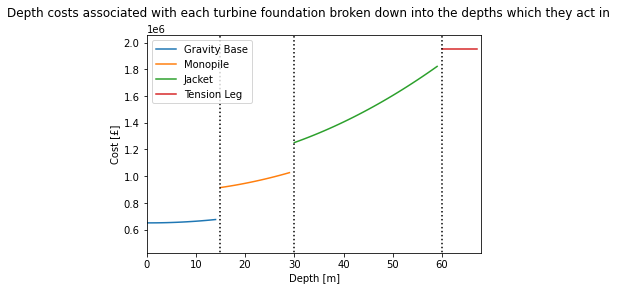

In [394]:
# Plots depth functions for each individual turbine foundation type but only considers the depths for which the foundation will act in

GBCost2 = GBCost[Depthx[0]:Depthx[15]]
MPCost2 = MPCost[Depthx[15]:Depthx[30]]
JCost2 = JCost[Depthx[30]:Depthx[60]]
TLCost2 = TLCost[Depthx[60]:max(Depthx)]

fig, ax = plt.subplots()
fig.suptitle('Depth costs associated with each turbine foundation broken down into the depths which they act in')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:15],GBCost2)
ax.plot(Depthx[15:30],MPCost2)
ax.plot(Depthx[30:60],JCost2)
ax.plot(Depthx[60:max(Depthx)],TLCost2)
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

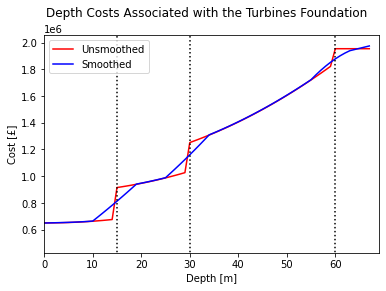

In [395]:
# Combines all the indivdual depths costs over there used depths into one plot and smooths the data

GBMPJTL = GBCost2+MPCost2+JCost2+TLCost2

fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with the Turbines Foundation')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH'])))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:max(Depthx)],GBMPJTL,color='r')
smoothed_2dg = savgol_filter(GBMPJTL, window_length = 9, polyorder = 1)
ax.plot(Depthx[0:max(Depthx)], smoothed_2dg, color='b')
plt.legend(['Unsmoothed','Smoothed'])
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')

In [396]:
def foundations(positionlist):
    
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    FoundationCost = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    FoundationCostTotal = 0 # Assigns initial value to variable
    
    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1])
        
        FoundationCost[i] = np.interp(DepthPerTurbine[i],Depthx[0:max(Depthx)],smoothed_2dg)

        FoundationCostTotal += FoundationCost[i]
        
    return FoundationCostTotal

FoundationCostTotal = foundations(positionlist)

In [397]:
# Function for calculated payback time, discounted payback time, Net Present Value, and Profitability Index

def Payback(TPO,TotalCost,positionlist):
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation at positonlist[0,:]
    
    CashFlowYearly = (ElectricityCostperkWh*24*365*(TPO/1000))-(OperatingandMaintenanceCostsperAnnum*nturb) # Calculates the yaerly cash flow for the windfarm
    PayBackTime = TotalCost/CashFlowYearly # calculates payback time in years
    DiscountedPayBackTime = (np.log(1/(1-((TotalCost*DiscountRate)/CashFlowYearly))))/np.log(1+DiscountRate) #Calculates payback time but takes into account the time value of money
    
    l=0
    NPV = 0
    
    for l in range(LifeTimeTurbineOperatingTime):
        l+=1
        NPV = NPV + (CashFlowYearly)/((1+DiscountRate)**l) #NPV is a method used to determine the current value of future cash flows generated by the project
    
    NPV = NPV - TotalCost
    ProfIndex = (NPV+TotalCost)/TotalCost # Probability index >1 it's profitable <1 its not
    
    return PayBackTime,DiscountedPayBackTime,NPV,ProfIndex

In [398]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance):
    
    mindepth = depthvalues(positionlist)[1]
    maxdepth = depthvalues(positionlist)[2]
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
    fig.suptitle('Plot Showing Sea Floor Topography and Turbines with Cables')
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    ax1.set_ylabel('y distance [m]') # y axis label
    ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    ax2.set_xlabel('x distance [m]') # x axis label
    ax2.set_ylabel('y distance [m]') # y axis label
    ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits
    
    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            ax1.plot(u,v, c='black')
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine 
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal 
    
    print('\033[1m'+'Maximum turbines per MST:'+'\033[0m', maximumturbinespertree)
    print('\033[1m'+'Number of turbines:'+'\033[0m', nturb)
    print()
    print('\033[1m'+'Inter-Array Cabling Costs: £'+'\033[0m', CableCost)
    print('\033[1m'+'Export Cabling Costs: £'+'\033[0m', ExportCableCost)
    print('\033[1m'+'Depth Cost: £'+'\033[0m', DepthCostAll)
    print('\033[1m'+'Foundations Cost: £'+'\033[0m', FoundationCostTotal)
    print('\033[1m'+'Turbine Cost: £'+'\033[0m', TurbineCostTotal)
    print('\033[1m'+'Land Cost: £'+'\033[0m', LandCost)
    print('\033[1m'+'Maintenance Cost: £'+'\033[0m', MaintenanceCosts)
    print('\033[1m'+'Fixed Cost:'+'\033[0m', FixedCost)
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow
    
    fig.subplots_adjust(left=0.1, right=0.8) #Adjusts plots to be able to fit a single color bar across both plots
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    tcf = ax1.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8]) #Locates colorbar across both subplots
    cbar = plt.colorbar(tcf,cax=cb_ax) #plots colorbar with location as stated by cb_ax
    cbar.set_label('Depth (m)')    
    
    ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    tcf = ax2.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')

    ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
    ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
    ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    fig, ax3 = plt.subplots()
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs','(Export) Cabling Costs','Foundation Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost,ExportCableCost,FoundationCostTotal] # Figures for each segment of pie chart
    
    ax3.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax3.axis('equal') #equal aspect ratio
    ax3.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

PRE-OPTIMISED LAYOUT INFORMATION

Maximum turbines per MST: 10
Number of turbines: 17

Inter-Array Cabling Costs: £ 2046000.0
Export Cabling Costs: £ 10507878.151260504
Depth Cost: £ 2825169.6412788685
Foundations Cost: £ 17320374.31398162
Turbine Cost: £ 37749814.95188749
Land Cost: £ 2310937.1732692444
Maintenance Cost: £ 22270000.0
Fixed Cost: 5464285.714285715

Budget: £ 100000000.0
Total Cost: £ 100494459.94596344
Total Power Output: 12048401.370771196 W
Theoretical Max Total Power Output: 14741731.221373294 W
Percentage power lost to wake effcts: 18.27010552666416 %
Cost per Watt 8.340895763130689 £/W

Payback Time: 7.134940303707842 years
Discounted Payback Time: 10.228395814343655 years
NPV: £ 48720487.193779826 over a  20 year period
Profitability Index: £ 1.4848076920854858 over a  20 year period


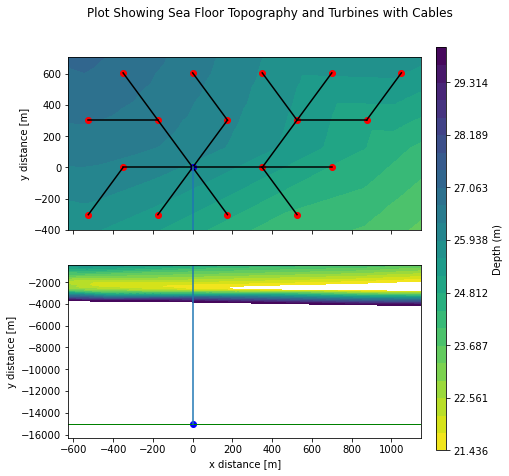

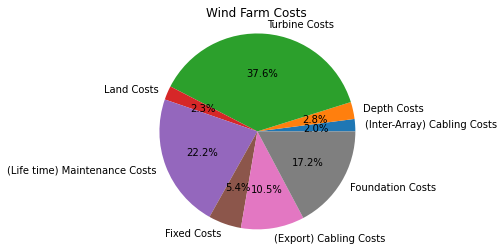

In [399]:
## Below calculates max theoreticl power output
wsr_noWake = np.ones(wsr.shape)
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power_pre = np.sum(output_noWake)

#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO
print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance)

PayBackTime,DiscountedPayBackTime,NPV,ProfIndex = Payback((np.sum(output)),TotalCost,positionlist)

# print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
# print('\033[1m'+'Cost per Watt:'+'\033[0m',TotalCost/np.sum(output),'£/W')
# print('')
# print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
# print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
# print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
# print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power_pre, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(np.sum(output)/theoretical_max_power_pre))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',TotalCost/np.sum(output),'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [400]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION
overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

Number of removed turbines: 0
new number of turbines: 17


C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [401]:
v=2
for amount in range(0,v):
    nturb = nturb - 1
    positionlist = np.delete(positionlist, len(positionlist)-1, 0)
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)

In [402]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []
smallestExportDistance = None

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    global smallestExportDistance

    arr2=np.reshape(coord_flat,(-1,2)) # undoes the coordinate flattening
    hull = ConvexHull(arr2)
    arr1 = np.array([np.mean(hull.points[hull.vertices,0]),np.mean(hull.points[hull.vertices,1])])
    arr1 = np.reshape(arr1,(-1,2))
    positionlist = np.concatenate((arr1,arr2),axis=0)
    #positionlist = np.reshape(coord_flat,(-1,2))#np.concatenate((arr1,arr2),axis=0) #np.reshape(coord_flat,(-1,2))
    
    nturb=np.size(positionlist,0)-1 # determines number of turbines (-1 due to the substation)
    print('nturb', nturb)
    
    OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) # calls clustering function
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist) # calls pre-MST function
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist) # Calls MST function
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)): 
        MSTWeightSum += MSTweight[a][0] 
        
    wsr=windspeedreduction(distance_global,angle_global,angles,model) # calls wake attenuation function
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2) # reduced power output due to wake effects
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost= (MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal= (nturb)*CostperTurbine
    MaintenanceCosts= (nturb)*MaintenanceCostperTurbine
    LandCost = LandAreaCost(positionlist,ExportDistance)
    #TotalCost= TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal
    red_fac_constant_depth = 1 ## reduction factor for constant depth
    TotalCost= red_fac_constant_depth*(TurbineCostTotal+MaintenanceCosts+FixedCost+ExportCableCost)+LandCost+CableCost
    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
        smallestExportDistance = ExportDistance

    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [403]:
# OPTIMIZATION

#xright = 0
#xleft = 0
#yup = 0
#ydown = 0
#for xright in range(0,nturb+1):
 #   if positionlist[xright,0]>0:
  #      positionlist[xright,0] = positionlist[xright,0] + 250
#for xleft in range(0,nturb+1):
 #   if positionlist[xleft,0]<0:
  #      positionlist[xleft,0] = positionlist[xleft,0] - 250
#for yup in range(0,nturb+1):
 #   if positionlist[yup,1]>0:
  #      positionlist[yup,1] = positionlist[yup,1] + 250
#for ydown in range(0,nturb+1):
 #   if positionlist[ydown,1]<0:
  #      positionlist[ydown,1] = positionlist[ydown,1] - 250
        
        
t1_start = perf_counter() # timer starts

while True:  
    
    iteration_time_start = perf_counter()
    
    #flat_coords=positionlist.flatten() # turns 2D coords into single list of data without any more structure.
    flat_coords=positionlist[1:,:].flatten() # turns 2D coords into single list of data without any more structure.
    dvel=1.5
    dang=5
    velocities=np.arange(Vc,Vf,dvel)
    angles=np.arange(0,360,dang)        
            
    # b = (Lower bound, Upper bound)
    b2 = ((min(positionlist[:,0]))-1000,(max(positionlist[:,0]))+1000) #bounds for x coordinates
    #b3 = ((OnshoreSubstation[1]+((TooCloseShore-2500))),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    b3 = (((min(positionlist[:,1]))-1000),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    bnd = (b2,b3) #bounds for x,y coordinates of each turbine 
    bnd1 = (bnd*(nturb)) #repeats bnd for the amount of turbines 
    bnds = bnd1 #Combines all bounds into a list for use in the optimization function
    
    #res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, bounds=bnds, options={'disp': 2, 'eps': 50, 'ftol': 1e-17, 'gtol': 1e-17})
    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, options={'disp': 2, 'eps': 50})#, 'ftol': 1e-17, 'gtol': 1e-17})

    #res = minimize(targetfunction, flat_coords, method='Nelder-Mead', jac=False, bounds=bnds, options={'disp': 2, 'xatol': 1e-3, 'fatol': 1e-3})#, 'ftol': 1e-17, 'gtol': 1e-17})
    #res = minimize(targetfunction, flat_coords, method='TNC', jac=False, bounds=bnds, options={'disp': 2, 'eps':50})#, 'ftol': 1e-17, 'gtol': 1e-17})
    
    iteration_time_end = perf_counter()
    print(iteration_time_end-iteration_time_start)
    
    if smallestTotalCost<=budget: #if under budget
        if not res.success:
            print(res.status, res.message) 
        else:
            break # Stops optimization when minimization is under budget after an iteration of 'minimize' 
    else: # over budget then removes a turbine and resets approrate varaibles 
        nturb = nturb - 1 
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        smallestExportDistance = None
        
        wsr=windspeedreduction(distance_global,angle_global,angles,model)
        powout=power(wsr,velocities) # total output power
        outputs=np.tensordot(powout,wsp,axes=2)
        LowestPower = min(outputs)
        LowestPowerIndex = np.argmin(outputs)
        LowestPowerTurbine = positionlist[LowestPowerIndex+1,:]
        positionlist = np.delete(positionlist, LowestPowerIndex+1, 0) 

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
          
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 15
Total power output in Watts 10837563.513168873 Total Cost in £ 72011705.91763873 £/W 6.644639805813947
smallest cost per watt 6.644639805813947
nturb 15
Total power output in Watts 10779857.77433672 Total Cost in £ 72014286.88491897 £/W 6.680448702798398
smallest cost per watt 6.644639805813947
nturb 15
Total power output in Watts 10798458.401994707 Total Cost in £ 71997624.8196738 £/W 6.667398450724623
smallest cost per watt 6.644639805813947
nturb 15
Total power output in Watts 10805702.27761536 Total Cost in £ 71994494.09250975 £/W 6.662639062493006
smallest cost per watt 6.644639805813947
nturb 15
Total power output in Watts 10804997.254129902 Total Cost in £ 72031059.82075611 £/W 6.66645794780043
smallest cost per watt 6.644639805813947
nturb 15
Total power output in Watts 10788166.087002488 Total Cost in £ 72035396.35023215 £/W 6.677260599187468
smallest cost per watt 6.644639805813947
nturb 15
Total power output in Watts 10782810.559809705 Total Cost in £ 72012546.35020

Total power output in Watts 10878165.168730015 Total Cost in £ 72155632.78110002 £/W 6.633070160445442
smallest cost per watt 6.627095578351321
nturb 15
Total power output in Watts 10864086.323203977 Total Cost in £ 72045089.78361262 £/W 6.631490917900354
smallest cost per watt 6.627095578351321
nturb 15
Total power output in Watts 10815884.815815827 Total Cost in £ 72073367.98217171 £/W 6.663658980241768
smallest cost per watt 6.627095578351321
nturb 15
Total power output in Watts 10885120.061549135 Total Cost in £ 72106348.56130476 £/W 6.624304385581836
smallest cost per watt 6.624304385581836
nturb 15
Total power output in Watts 10814142.580164583 Total Cost in £ 72073237.8439716 £/W 6.664720509249536
smallest cost per watt 6.624304385581836
nturb 15
Total power output in Watts 10884910.55409533 Total Cost in £ 72184920.3425249 £/W 6.6316503000905325
smallest cost per watt 6.624304385581836
nturb 15
Total power output in Watts 10790347.605904808 Total Cost in £ 72057761.74334224 £/W

Total power output in Watts 10800757.938943554 Total Cost in £ 72080449.44957963 £/W 6.673647336330359
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10855349.216177817 Total Cost in £ 72199927.7616727 £/W 6.651092131985266
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10762216.098111881 Total Cost in £ 72006067.11852007 £/W 6.690635688977922
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10870344.822436636 Total Cost in £ 72114154.02519009 £/W 6.634026353639201
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10782684.701533927 Total Cost in £ 72083637.66008575 £/W 6.685128950291133
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10871455.962129971 Total Cost in £ 72145687.37152869 £/W 6.636248872537737
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10785532.272388615 Total Cost in £ 72130678.59157206 £/

Total power output in Watts 10820475.151026603 Total Cost in £ 72098332.76388244 £/W 6.663139257525308
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10817571.18868189 Total Cost in £ 71996487.75328112 £/W 6.655513192148803
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10840463.953517996 Total Cost in £ 72069994.54028015 £/W 6.648238936018202
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10774381.33207425 Total Cost in £ 72013372.36755657 £/W 6.6837593870174254
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10799741.293796204 Total Cost in £ 71994767.76265031 £/W 6.666341887653081
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10826501.402345775 Total Cost in £ 71994512.64032781 £/W 6.649840974918156
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10801590.53372686 Total Cost in £ 71997165.89247343 £/W

Total power output in Watts 10779857.77433672 Total Cost in £ 72148977.02339388 £/W 6.692943314628581
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10798458.401994707 Total Cost in £ 72155728.07785217 £/W 6.682039731201211
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10805702.27761536 Total Cost in £ 72078360.2470343 £/W 6.6704003492997215
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10804997.254129902 Total Cost in £ 72175744.73871063 £/W 6.679848503536038
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10788166.087002488 Total Cost in £ 72077978.098693 £/W 6.6812076786185255
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10782810.559809705 Total Cost in £ 72084148.72927275 £/W 6.68509831731152
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10785429.898221815 Total Cost in £ 72185458.05336829 £/W 6

nturb 15
Total power output in Watts 10812865.283807993 Total Cost in £ 71986903.55814901 £/W 6.657523391690423
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10882454.383137738 Total Cost in £ 72119065.32410206 £/W 6.627095578351321
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10811263.650189012 Total Cost in £ 72025762.59292659 £/W 6.662103980016006
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10882249.015707685 Total Cost in £ 72122130.21869192 £/W 6.627502285105698
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10787338.853812912 Total Cost in £ 72026983.32507306 £/W 6.6769927505905935
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10879668.559030212 Total Cost in £ 72101694.25684533 £/W 6.627195843847682
smallest cost per watt 6.623134337673537
nturb 15
Total power output in Watts 10837563.513168873 Total Cost in £ 72011705.

In [404]:
#DEFINES OPTIMAL LAYOUT USING DATA TAKEN FROM OPTIMISATION
distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)
## Below calculates max theoreticl power output
wsr_noWake = np.ones(wsr.shape)
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)

print(f'smallestpositionlist.shape = {smallestpositionlist.shape}\nangles.shape = {angles.shape}')

smallestpositionlist.shape = (16, 2)
angles.shape = (72,)


POST-OPTIMISED LAYOUT INFORMATION (ATTENUATION TESTING)

Maximum turbines per MST: 10
Number of turbines: 15

Inter-Array Cabling Costs: £ 1654436.758591966
Export Cabling Costs: £ 10624218.692496782
Depth Cost: £ 2448701.8097852203
Foundations Cost: £ 15219890.557602208
Turbine Cost: £ 33308660.25166543
Land Cost: £ 2016571.2516113878
Maintenance Cost: £ 19650000.0
Fixed Cost: 4821428.571428571

Budget: £ 100000000.0
Total Cost: £ 89743907.89318156
Total Power Output: 10882357.48379996 W
Theoretical Max Total Power Output: 13007409.90121173 W
Percentage power lost to wake effcts: 16.337244951539553 %
Cost per Watt 6.623134337673537 £/W

Payback Time: 5.655209811328831 years
Discounted Payback Time: 7.448524157922203 years
NPV: £ 62944771.24458793 over a  20 year period
Profitability Index: £ 1.873319399095262 over a  20 year period


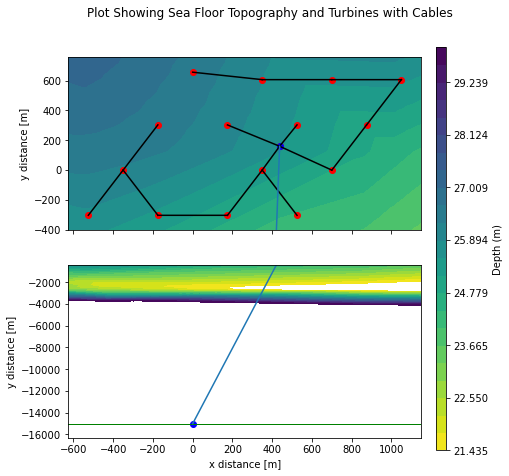

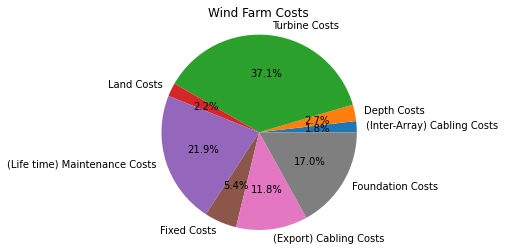

In [405]:
#DISPLAYS OPTIMAL LAYOUT (shows 33 and base)

print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (ATTENUATION TESTING)'+'\033[0m'+'\033[0m')
print()
OptimizedTPO = smallestTotalCost/smallestCostPerWatt
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data,OnshoreSubstation,smallestExportDistance)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(OptimizedTPO,smallestTotalCost,smallestpositionlist)

print('\033[1m'+'Total Power Output:'+'\033[0m', OptimizedTPO, 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(OptimizedTPO/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [406]:
## SAVE VARIABLE TO FILE FOR USE IN GAUSSIAN CODE
import pickle

optimised_farm_variables = {'smallestpositionlist': smallestpositionlist, 'smallestindiceslist': smallestindiceslist, 'OptimizedTPO': OptimizedTPO, 'smallestTotalCost': smallestTotalCost, 'smallestCostPerWatt': smallestCostPerWatt, 'smallestExportDistance': smallestExportDistance, 'MSTWeightSum':MSTWeightSum}
with open('optimised_farm_variables.pkl', 'wb') as f:
    pickle.dump(optimised_farm_variables, f)

In [407]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.

In [408]:
print(res.success) # whether the minization was succesful or not
print(res.status) # termination status
print(res.message) # Description of the cause of termination
print(res.nit) # number of iterations performed by the optimizer

True
0
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
1
